# Predictive Election NN Model

Using the cleaned registration and election result data, built a neural network model for predicting outcomes of elections. Input features are:

* Partisan registration in upcoming election
* Partisan registration in prior election
* Outcome of prior election

One of the challenges with predicting election outcomes in Colorado is the variability due to about a third of the state being unaffiliated with the two major parties. The behavior of those unaffiliateds with vary by district, so we need a model that can account for that.

We have a pretty limited dataset, using the following combinations

| Inputs | Output |
|---------|----------|
|2012 reg., results, 2014 reg. | 2014 results |
|2014 reg., results, 2014 reg. | 2016 results |
|2016 reg., results, 2016 reg. | 2018 results |
|2018 reg., results, 2020 reg. | 2020 results |

with the final goal of using the 2018 reg. and results + the most current 2020 reg. to predict the 2020 results.

In [1]:
# Useful imports
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise
from tensorflow import keras

from matplotlib import pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

# needed for our loss plots
from IPython.display import clear_output

%matplotlib inline

res_dir = '../data/results/cleaned'
reg_dir = '../data/registration/cleaned'

build_models = False

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()      
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.loglog(self.x, self.losses, label="loss")
        plt.loglog(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.ylabel('error')
        plt.xlabel('epoch')
        plt.show();
        
plot_losses = PlotLosses()

## Data Preparation

Need to arrange the cleaned CSV files into the inputs and outputs with appropriate groupings.

Senate elections are every four years, so prior results from 2012 will be paired with registration in 2016 to predict the 2016 outcome. Similarly with 2014 and 2018.

First, define some helper functions that will pre-process the data from the cleaned registration and results files

In [3]:
def get_registration(year):
    """Given an input year, snag the registration data for that year and collapse the affiliation of active
    voters into REP, DEM, OTHER
    
    Returns a dataframe with columns DISTRICT-COUNTY, REP, DEM, OTHERS"""
    
    # read in the data
    reg_df = pd.read_csv(reg_dir+'/house_{}.csv'.format(year))
    
    # filter out where the county value is empty, which is a "total" row
    reg_df = reg_df[reg_df['COUNTY'].notnull()]
    
    # isolate only active voters
    active_cols = [col for col in reg_df.columns if '-ACTIVE' in col]
    
    # find third-party/unaffiliated voter data
    other_cols = [col for col in active_cols if 'DEM' not in col and 'REP' not in col]
    
    # combine all unaffiliateds into one column
    reg_df['OTHER-ACTIVE'] = reg_df[other_cols].sum(axis=1)
    
    # combine the district and county labels into one
    reg_df['DIST_COUNTY'] = reg_df['DISTRICT'].astype(str) +'-'+ reg_df['COUNTY'].astype(str)

    # pick off only the interesting data
    relabel_dict = {
        'REP-ACTIVE' : 'REP',
        'DEM-ACTIVE' : 'DEM',
        'OTHER-ACTIVE' : 'OTHER'
    }
    new_df = reg_df[['DIST_COUNTY', 'REP-ACTIVE', 'DEM-ACTIVE', 'OTHER-ACTIVE']].rename(columns=relabel_dict)
    
    return new_df
    
def get_results(year):
    """Given an input year, snag the results data for that year and collapse the affiliation of active
    candidates into REP, DEM, OTHER
    
    Returns a dataframe with columns DISTRICT-COUNTY, REP, DEM, OTHERS"""

    # read in the results file
    df = pd.read_csv(res_dir+'/house_{}.csv'.format(year))
    
    # create a DIST-COUNTY label
    df['DIST_COUNTY'] = df['DISTRICT'].astype(str) + '-' + df['COUNTY'].astype(str)
    
    # isolate third party candidates
    parties = ['DEMOCRATIC PARTY', 'REPUBLICAN PARTY']
    df['PARTY'][~df['PARTY'].isin(parties)] = 'OTHER'
    df['PARTY'][df['PARTY'] == 'REPUBLICAN PARTY'] = 'REP'
    df['PARTY'][df['PARTY'] == 'DEMOCRATIC PARTY'] = 'DEM'

    # sum over precincts, if precincts exist
    agg_cols = {'YES VOTES' : 'sum'}
    df = df.groupby([df['DIST_COUNTY'], df['PARTY']], as_index=False).aggregate(agg_cols)
    
    # Make party votes into columns for each DIST_COUNTY
    df = df.pivot(index='DIST_COUNTY', columns='PARTY', values='YES VOTES').fillna(0)
    df.reset_index(level=0, inplace=True)

    return df

At this point, it is helpful to combine the all the relevant input and output data for each dist-county into a single input and output dataframe.

In [4]:
# Will store the district-county data using the standard key format 
# 'SD [NUMBER]-[COUNTY]' for the Year of the Predicted Results
year_pairs = [['2012', '2014'], ['2014', '2016'], ['2016', '2018']]

X_set = np.array([], dtype=np.float64).reshape(0,9)
Y_set = np.array([], dtype=np.float64).reshape(0,3)

dfs = []

for pair in year_pairs:
    
    # The output variables
    current_result = get_results(pair[1])
    elections = current_result.DIST_COUNTY.unique()
    current_result = current_result.rename(
        columns={'DEM' : 'DEM_curr_votes',
                 'REP' : 'REP_curr_votes',
                 'OTHER' : 'OTHER_curr_votes'}
    )
        
    # The input variables
    
    # current registration
    current_reg = get_registration(pair[1])
    current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]
        
    current_reg = current_reg.rename(
        columns={'DEM' : 'DEM_curr_reg',
                 'REP' : 'REP_curr_reg',
                 'OTHER' : 'OTHER_curr_reg'}
    )
    
    # prior election registration
    past_reg = get_registration(pair[0])
    past_reg = past_reg[past_reg['DIST_COUNTY'].isin(elections)]
    
    past_reg = past_reg.rename(
        columns={'DEM' : 'DEM_past_reg',
                 'REP' : 'REP_past_reg',
                 'OTHER' : 'OTHER_past_reg'}
    )
    
    # prior election result registration
    past_result = get_results(pair[0])
    past_result = past_result[past_result['DIST_COUNTY'].isin(elections)]
    
    past_result = past_result.rename(
        columns={'DEM' : 'DEM_past_votes',
                 'REP' : 'REP_past_votes',
                 'OTHER' : 'OTHER_past_votes'}
    )
    
    # compute fractional current registration
    tot_regs = current_reg.sum(axis=1).values
    current_reg.DEM_curr_reg  = current_reg.DEM_curr_reg.values/tot_regs
    current_reg.REP_curr_reg  = current_reg.REP_curr_reg.values/tot_regs
    current_reg.OTHER_curr_reg = current_reg.OTHER_curr_reg.values/tot_regs
    
    # compute fractional past registration
    tot_regs = past_reg.sum(axis=1).values
    past_reg.DEM_past_reg  = past_reg.DEM_past_reg.values/tot_regs
    past_reg.REP_past_reg  = past_reg.REP_past_reg.values/tot_regs
    past_reg.OTHER_past_reg = past_reg.OTHER_past_reg.values/tot_regs
    
    # compute fractional past votes
    tot_votes = past_result.sum(axis=1).values
    past_result.DEM_past_votes = past_result.DEM_past_votes.values/tot_votes
    past_result.REP_past_votes = past_result.REP_past_votes.values/tot_votes
    past_result.OTHER_past_votes = past_result.OTHER_past_votes.values/tot_votes

    X_df = current_reg
    X_df = pd.merge(X_df, past_reg, on='DIST_COUNTY')
    X_df = pd.merge(X_df, past_result, on='DIST_COUNTY')
    
    # Now for the outputs
    # compute current fractional votes
    tot_votes = current_result.sum(axis=1).values
    current_result.DEM_curr_votes = current_result.DEM_curr_votes.values/tot_votes
    current_result.REP_curr_votes = current_result.REP_curr_votes.values/tot_votes
    current_result.OTHER_curr_votes = current_result.OTHER_curr_votes.values/tot_votes

    X_df = pd.merge(X_df, current_result, on='DIST_COUNTY')
    
    dfs.append(X_df)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
result = pd.concat(dfs)
X_cols = ['REP_curr_reg', 'DEM_curr_reg', 'OTHER_curr_reg',
          'REP_past_reg', 'DEM_past_reg', 'OTHER_past_reg',
          'REP_past_votes', 'DEM_past_votes', 'OTHER_past_votes']
Y_cols = ['DEM_curr_votes', 'OTHER_curr_votes', 'REP_curr_votes']

print(result[Y_cols])

X_set = result[X_cols].values
Y_set = result[Y_cols].values

     DEM_curr_votes  OTHER_curr_votes  REP_curr_votes
0          0.551881          0.072698        0.375421
1          0.382550          0.053691        0.563758
2          0.726058          0.000000        0.273942
3          0.507252          0.000000        0.492748
4          0.780595          0.000000        0.219405
..              ...               ...             ...
112        0.220130          0.000000        0.779870
113        0.277128          0.000000        0.722872
114        0.218080          0.000000        0.781920
115        0.235294          0.000000        0.764706
116        0.259542          0.000000        0.740458

[351 rows x 3 columns]


## Model Training

### Split the Data

Split into a train-test split to validate the data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
print(np.shape(X_set))
X_test, X_train, Y_test, Y_train = train_test_split(X_set, Y_set, train_size=.2)
print(np.shape(X_test))

(351, 9)
(70, 9)


### Train a Model

This is a small dataset, so we need to use a very shallow neural network

In [8]:
model = Sequential()

model.add(Dense(2, input_dim=9, activation='tanh'))
model.add(GaussianNoise(stddev=.1))
#model.add(Dense(2, activation='tanh'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

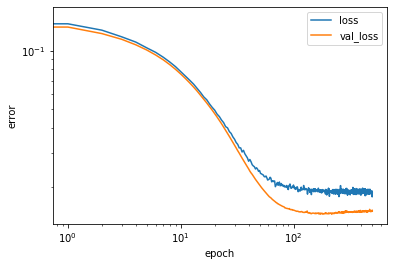

In [9]:
hist = model.fit(x=X_train, y=Y_train, 
                    validation_data= (X_test, Y_test),
                    batch_size = 10,
                    shuffle = True,
                    epochs = 500,
                    verbose = False,
                    callbacks = [plot_losses])

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'validation loss')

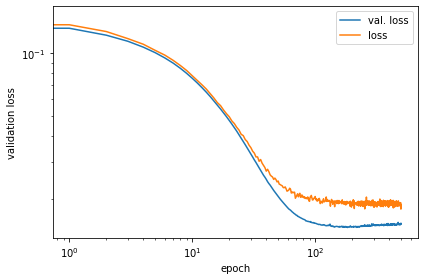

In [10]:
plt.figure()
plt.loglog(hist.epoch, hist.history['val_loss'], label = 'val. loss')
plt.loglog(hist.epoch, hist.history['loss'], label = 'loss')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.legend()
plt.tight_layout()
plt.savefig('election_model.png')

### Train an ensemble of models

Because of the small number of data points, uncertainty quantification is important. So, build an ensemble of models from different training data, and then make the predictions using the average/spread of each model.

For a 20% train-test split, there are $\binom{89}{71} \approx 3 \times 10^{18}$ possible combinations. So, we aren't too worried about repeats.

In [11]:
if build_models:
    n_models = 1000
    train_size = .3
    models_dict = {}

    losses = []
    vals = []

    for model_num in tqdm(range(n_models)):

        X_test, X_train, Y_test, Y_train = train_test_split(X_set, Y_set, train_size=train_size)
        model = Sequential()

        model.add(Dense(2, input_dim=9, activation='tanh'))
        model.add(GaussianNoise(stddev=.1))
        model.add(Dense(3, activation='sigmoid'))

        model.compile(loss='mean_squared_error', optimizer='adam')

        hist = model.fit(x=X_train, y=Y_train, 
                        validation_data= (X_test, Y_test),
                        batch_size = 20,
                        shuffle = True,
                        epochs = 100,
                        verbose = False)

        models_dict['model {}'.format(model_num)] = model
        losses.append(hist.history['loss'][-1])
        vals.append(hist.history['val_loss'][-1])

    #    print('final loss = {}'.format(hist.history['loss'][-1]))
    #    print('final val. loss = {}\n'.format(hist.history['val_loss'][-1]))
    for model in models_dict:
    
        models_dict[model].save('./model/house_{}'.format(model))
    
    plt.scatter(losses, vals)

## 2020 Predictions

In [12]:
pair = ['2018', '2020']

# The input variables

# prior election result registration
past_result = get_results(pair[0])
elections = past_result['DIST_COUNTY'].unique()
past_result = past_result[past_result['DIST_COUNTY'].isin(elections)]

past_result = past_result.rename(
    columns={'DEM' : 'DEM_past_votes',
             'REP' : 'REP_past_votes',
             'OTHER' : 'OTHER_past_votes'}
)

# current registration
current_reg = get_registration(pair[1])
current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]

current_reg = current_reg.rename(
    columns={'DEM' : 'DEM_curr_reg',
             'REP' : 'REP_curr_reg',
             'OTHER' : 'OTHER_curr_reg'}
)

# prior election registration
past_reg = get_registration(pair[0])
past_reg = past_reg[past_reg['DIST_COUNTY'].isin(elections)]

past_reg = past_reg.rename(
    columns={'DEM' : 'DEM_past_reg',
             'REP' : 'REP_past_reg',
             'OTHER' : 'OTHER_past_reg'}
)

# compute fractional current registration
tot_regs = current_reg.sum(axis=1).values
current_reg.DEM_curr_reg  = current_reg.DEM_curr_reg.values/tot_regs
current_reg.REP_curr_reg  = current_reg.REP_curr_reg.values/tot_regs
current_reg.OTHER_curr_reg = current_reg.OTHER_curr_reg.values/tot_regs

# compute fractional past registration
tot_regs = past_reg.sum(axis=1).values
past_reg.DEM_past_reg  = past_reg.DEM_past_reg.values/tot_regs
past_reg.REP_past_reg  = past_reg.REP_past_reg.values/tot_regs
past_reg.OTHER_past_reg = past_reg.OTHER_past_reg.values/tot_regs

# compute fractional past votes
tot_votes = past_result.sum(axis=1).values
past_result.DEM_past_votes = past_result.DEM_past_votes.values/tot_votes
past_result.REP_past_votes = past_result.REP_past_votes.values/tot_votes
past_result.OTHER_past_votes = past_result.OTHER_past_votes.values/tot_votes


X_df = current_reg
X_df = pd.merge(X_df, past_reg, on='DIST_COUNTY')
X_df = pd.merge(X_df, past_result, on='DIST_COUNTY')

X_pred = X_df[X_cols].values

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iterate over all models, get the predicted vote totals by district-county for each model, and store. We will eventually compute total and spread of votes in each district

In [13]:
import glob

models = glob.glob('./model/*')

current_reg = get_registration(pair[1])
current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]
tot_regs = current_reg.sum(axis=1).values
tot_regs = np.reshape(tot_regs, (len(tot_regs),1))

preds_array = []

for model in tqdm(models):
    this_model = keras.models.load_model(model)
    preds = this_model.predict(X_pred)
    preds_array.append(preds*tot_regs)

In [14]:
mean_df = pd.DataFrame(data = {'DIST_COUNTY' : current_reg.DIST_COUNTY.values,
                              'DEM' : np.mean(preds_array, axis=0)[:,0],
                              'REP' : np.mean(preds_array, axis=0)[:,2],
                              'OTHER' : np.mean(preds_array, axis=0)[:,1]})

print(mean_df)

std_df = pd.DataFrame(data = {'DIST_COUNTY' : current_reg.DIST_COUNTY.values,
                              'DEM' : np.std(preds_array, axis=0)[:,0],
                              'REP' : np.std(preds_array, axis=0)[:,2],
                              'OTHER' : np.std(preds_array, axis=0)[:,1]})

print(std_df)

        DIST_COUNTY           DEM           REP        OTHER
0       HD 1-DENVER  24536.045356  16233.910350  4195.828555
1    HD 1-JEFFERSON    102.734440    119.763404    18.521006
2       HD 2-DENVER  41688.941859  20377.672851  8265.303539
3     HD 3-ARAPAHOE  28811.031823  22584.032442  4841.725381
4       HD 4-DENVER  31764.147140  16478.475958  5985.422015
..              ...           ...           ...          ...
112     HD 65-LOGAN   3712.011342   7506.014989   950.723328
113    HD 65-MORGAN   5821.925605   9586.333545  1254.673952
114  HD 65-PHILLIPS    829.364107   1795.056846   228.121793
115  HD 65-SEDGWICK    510.768692   1064.921235   134.969483
116      HD 65-YUMA   1782.682054   3651.645873   463.039883

[117 rows x 4 columns]
        DIST_COUNTY          DEM          REP        OTHER
0       HD 1-DENVER  3596.668061  3594.653445  1558.049069
1    HD 1-JEFFERSON     5.409867     5.175038     5.078774
2       HD 2-DENVER  7638.531511  7496.389303  4258.904597
3     HD

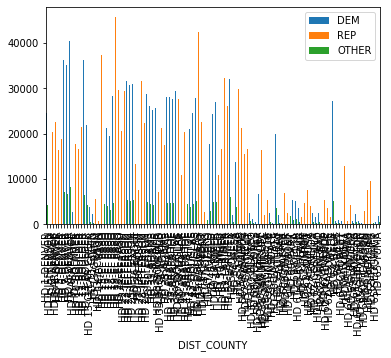

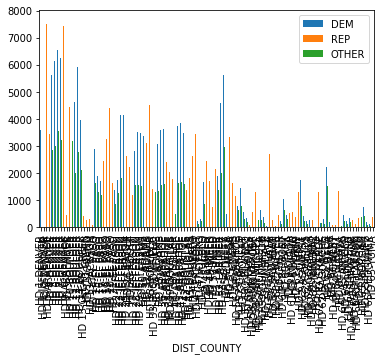

In [15]:
mean_df.plot.bar(x='DIST_COUNTY')
std_df.plot.bar(x='DIST_COUNTY')

In [16]:
mean_df['DISTRICT'] = mean_df['DIST_COUNTY'].str.split('-').str[0]
std_df['DISTRICT'] = std_df['DIST_COUNTY'].str.split('-').str[0]

mean_df['COUNTY'] = mean_df['DIST_COUNTY'].str.split('-').str[1]
std_df['COUNTY'] = std_df['DIST_COUNTY'].str.split('-').str[1]

print(mean_df)
print(std_df)

        DIST_COUNTY           DEM           REP        OTHER DISTRICT  \
0       HD 1-DENVER  24536.045356  16233.910350  4195.828555     HD 1   
1    HD 1-JEFFERSON    102.734440    119.763404    18.521006     HD 1   
2       HD 2-DENVER  41688.941859  20377.672851  8265.303539     HD 2   
3     HD 3-ARAPAHOE  28811.031823  22584.032442  4841.725381     HD 3   
4       HD 4-DENVER  31764.147140  16478.475958  5985.422015     HD 4   
..              ...           ...           ...          ...      ...   
112     HD 65-LOGAN   3712.011342   7506.014989   950.723328    HD 65   
113    HD 65-MORGAN   5821.925605   9586.333545  1254.673952    HD 65   
114  HD 65-PHILLIPS    829.364107   1795.056846   228.121793    HD 65   
115  HD 65-SEDGWICK    510.768692   1064.921235   134.969483    HD 65   
116      HD 65-YUMA   1782.682054   3651.645873   463.039883    HD 65   

        COUNTY  
0       DENVER  
1    JEFFERSON  
2       DENVER  
3     ARAPAHOE  
4       DENVER  
..         ...  
112 

### Election Predictions

Here are the total vote predictions for each district. We start with a bar chart and STD range of predictions. We will also look at the individual predictions and win percentages.

Text(0.5, 1.0, 'District HD 1 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '24,638')

Text(0, 3, '16,353')

Text(0, 3, '4,214')

Text(0.5, 1.0, 'District HD 2 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '41,688')

Text(0, 3, '20,377')

Text(0, 3, '8,265')

Text(0.5, 1.0, 'District HD 3 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,811')

Text(0, 3, '22,584')

Text(0, 3, '4,841')

Text(0.5, 1.0, 'District HD 4 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '31,764')

Text(0, 3, '16,478')

Text(0, 3, '5,985')

Text(0.5, 1.0, 'District HD 5 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '35,203')

Text(0, 3, '18,832')

Text(0, 3, '6,517')

Text(0.5, 1.0, 'District HD 6 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '36,365')

Text(0, 3, '18,407')

Text(0, 3, '7,070')

Text(0.5, 1.0, 'District HD 7 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '35,071')

Text(0, 3, '17,989')

Text(0, 3, '6,659')

Text(0.5, 1.0, 'District HD 8 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '40,551')

Text(0, 3, '18,956')

Text(0, 3, '8,314')

Text(0.5, 1.0, 'District HD 9 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '31,395')

Text(0, 3, '19,280')

Text(0, 3, '5,482')

Text(0.5, 1.0, 'District HD 10 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'BOULDER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '33,265')

Text(0, 3, '16,662')

Text(0, 3, '6,420')

Text(0.5, 1.0, 'District HD 11 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'BOULDER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '32,119')

Text(0, 3, '21,560')

Text(0, 3, '5,482')

Text(0.5, 1.0, 'District HD 12 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'BOULDER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '36,297')

Text(0, 3, '22,007')

Text(0, 3, '6,519')

Text(0.5, 1.0, 'District HD 13 Predictions')

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

[Text(0, 0, 'BOULDER'),
 Text(0, 0, 'CLEAR CREEK'),
 Text(0, 0, 'GILPIN'),
 Text(0, 0, 'GRAND'),
 Text(0, 0, 'JACKSON'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '33,252')

Text(0, 3, '22,517')

Text(0, 3, '6,247')

Text(0.5, 1.0, 'District HD 14 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '22,635')

Text(0, 3, '37,353')

Text(0, 3, '4,892')

Text(0.5, 1.0, 'District HD 15 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '22,768')

Text(0, 3, '31,389')

Text(0, 3, '4,407')

Text(0.5, 1.0, 'District HD 16 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '21,177')

Text(0, 3, '28,536')

Text(0, 3, '4,050')

Text(0.5, 1.0, 'District HD 17 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '19,454')

Text(0, 3, '15,124')

Text(0, 3, '3,264')

Text(0.5, 1.0, 'District HD 18 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,331')

Text(0, 3, '23,174')

Text(0, 3, '4,769')

Text(0.5, 1.0, 'District HD 19 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '23,173')

Text(0, 3, '45,698')

Text(0, 3, '5,799')

Text(0.5, 1.0, 'District HD 20 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '20,725')

Text(0, 3, '29,694')

Text(0, 3, '4,093')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Text(0.5, 1.0, 'District HD 21 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '17,528')

Text(0, 3, '20,555')

Text(0, 3, '3,155')

Text(0.5, 1.0, 'District HD 22 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '25,955')

Text(0, 3, '29,400')

Text(0, 3, '4,622')

Text(0.5, 1.0, 'District HD 23 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '31,539')

Text(0, 3, '23,023')

Text(0, 3, '5,316')

Text(0.5, 1.0, 'District HD 24 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '30,821')

Text(0, 3, '22,179')

Text(0, 3, '5,203')

Text(0.5, 1.0, 'District HD 25 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '30,892')

Text(0, 3, '30,021')

Text(0, 3, '5,289')

Text(0.5, 1.0, 'District HD 26 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'EAGLE'), Text(0, 0, 'ROUTT'), Text(0, 0, 'TOTAL')]

Text(0, 3, '27,016')

Text(0, 3, '20,855')

Text(0, 3, '4,546')

Text(0.5, 1.0, 'District HD 27 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '32,765')

Text(0, 3, '31,729')

Text(0, 3, '5,594')

Text(0.5, 1.0, 'District HD 28 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,929')

Text(0, 3, '22,398')

Text(0, 3, '4,857')

Text(0.5, 1.0, 'District HD 29 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,845')

Text(0, 3, '22,744')

Text(0, 3, '4,845')

Text(0.5, 1.0, 'District HD 30 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '26,228')

Text(0, 3, '19,785')

Text(0, 3, '4,398')

Text(0.5, 1.0, 'District HD 31 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '25,279')

Text(0, 3, '19,916')

Text(0, 3, '4,239')

Text(0.5, 1.0, 'District HD 32 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '25,601')

Text(0, 3, '12,976')

Text(0, 3, '4,969')

Text(0.5, 1.0, 'District HD 33 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'BOULDER'), Text(0, 0, 'BROOMFIELD'), Text(0, 0, 'TOTAL')]

Text(0, 3, '35,669')

Text(0, 3, '28,415')

Text(0, 3, '6,012')

Text(0.5, 1.0, 'District HD 34 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '23,696')

Text(0, 3, '17,578')

Text(0, 3, '3,983')

Text(0.5, 1.0, 'District HD 35 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,077')

Text(0, 3, '21,013')

Text(0, 3, '4,720')

Text(0.5, 1.0, 'District HD 36 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,128')

Text(0, 3, '20,816')

Text(0, 3, '4,730')

Text(0.5, 1.0, 'District HD 37 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '27,715')

Text(0, 3, '26,145')

Text(0, 3, '4,720')

Text(0.5, 1.0, 'District HD 38 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '29,391')

Text(0, 3, '30,658')

Text(0, 3, '5,108')

Text(0.5, 1.0, 'District HD 39 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'DOUGLAS'), Text(0, 0, 'TELLER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '23,991')

Text(0, 3, '38,689')

Text(0, 3, '5,114')

Text(0.5, 1.0, 'District HD 40 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '28,223')

Text(0, 3, '20,430')

Text(0, 3, '4,760')

Text(0.5, 1.0, 'District HD 41 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '26,762')

Text(0, 3, '17,911')

Text(0, 3, '4,561')

Text(0.5, 1.0, 'District HD 42 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '21,131')

Text(0, 3, '12,180')

Text(0, 3, '3,769')

Text(0.5, 1.0, 'District HD 43 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DOUGLAS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '24,610')

Text(0, 3, '30,295')

Text(0, 3, '4,524')

Text(0.5, 1.0, 'District HD 44 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DOUGLAS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '27,965')

Text(0, 3, '35,983')

Text(0, 3, '5,237')

Text(0.5, 1.0, 'District HD 45 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DOUGLAS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '27,856')

Text(0, 3, '42,391')

Text(0, 3, '5,709')

Text(0.5, 1.0, 'District HD 46 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'PUEBLO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '29,000')

Text(0, 3, '22,527')

Text(0, 3, '4,870')

Text(0.5, 1.0, 'District HD 47 Predictions')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

[Text(0, 0, 'FREMONT'),
 Text(0, 0, 'OTERO'),
 Text(0, 0, 'PUEBLO'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '24,396')

Text(0, 3, '24,110')

Text(0, 3, '4,246')

Text(0.5, 1.0, 'District HD 48 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'WELD'), Text(0, 0, 'TOTAL')]

Text(0, 3, '24,300')

Text(0, 3, '37,473')

Text(0, 3, '5,012')

Text(0.5, 1.0, 'District HD 49 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'LARIMER'), Text(0, 0, 'WELD'), Text(0, 0, 'TOTAL')]

Text(0, 3, '33,690')

Text(0, 3, '44,496')

Text(0, 3, '6,412')

Text(0.5, 1.0, 'District HD 50 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'WELD'), Text(0, 0, 'TOTAL')]

Text(0, 3, '19,371')

Text(0, 3, '16,646')

Text(0, 3, '3,254')

Text(0.5, 1.0, 'District HD 51 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'LARIMER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '27,278')

Text(0, 3, '32,203')

Text(0, 3, '4,927')

Text(0.5, 1.0, 'District HD 52 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'LARIMER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '35,335')

Text(0, 3, '26,075')

Text(0, 3, '5,960')

Text(0.5, 1.0, 'District HD 53 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'LARIMER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '32,059')

Text(0, 3, '17,008')

Text(0, 3, '6,093')

Text(0.5, 1.0, 'District HD 54 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'DELTA'), Text(0, 0, 'MESA'), Text(0, 0, 'TOTAL')]

Text(0, 3, '15,814')

Text(0, 3, '34,544')

Text(0, 3, '4,470')

Text(0.5, 1.0, 'District HD 55 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'MESA'), Text(0, 0, 'TOTAL')]

Text(0, 3, '21,464')

Text(0, 3, '29,825')

Text(0, 3, '4,169')

Text(0.5, 1.0, 'District HD 56 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '29,994')

Text(0, 3, '36,842')

Text(0, 3, '5,499')

Text(0.5, 1.0, 'District HD 57 Predictions')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

[Text(0, 0, 'GARFIELD'),
 Text(0, 0, 'MOFFAT'),
 Text(0, 0, 'RIO BLANCO'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '19,799')

Text(0, 3, '24,822')

Text(0, 3, '3,850')

Text(0.5, 1.0, 'District HD 58 Predictions')

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

[Text(0, 0, 'DOLORES'),
 Text(0, 0, 'MONTEZUMA'),
 Text(0, 0, 'MONTROSE'),
 Text(0, 0, 'SAN MIGUEL'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '20,167')

Text(0, 3, '29,330')

Text(0, 3, '4,215')

Text(0.5, 1.0, 'District HD 59 Predictions')

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

[Text(0, 0, 'ARCHULETA'),
 Text(0, 0, 'GUNNISON'),
 Text(0, 0, 'HINSDALE'),
 Text(0, 0, 'LA PLATA'),
 Text(0, 0, 'OURAY'),
 Text(0, 0, 'SAN JUAN'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '29,016')

Text(0, 3, '27,495')

Text(0, 3, '5,288')

Text(0.5, 1.0, 'District HD 60 Predictions')

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

[Text(0, 0, 'CHAFFEE'),
 Text(0, 0, 'CUSTER'),
 Text(0, 0, 'FREMONT'),
 Text(0, 0, 'PARK'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '22,104')

Text(0, 3, '31,236')

Text(0, 3, '4,401')

Text(0.5, 1.0, 'District HD 61 Predictions')

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

[Text(0, 0, 'DELTA'),
 Text(0, 0, 'GUNNISON'),
 Text(0, 0, 'LAKE'),
 Text(0, 0, 'PITKIN'),
 Text(0, 0, 'SUMMIT'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '31,172')

Text(0, 3, '24,549')

Text(0, 3, '5,604')

Text(0.5, 1.0, 'District HD 62 Predictions')

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

[Text(0, 0, 'ALAMOSA'),
 Text(0, 0, 'CONEJOS'),
 Text(0, 0, 'COSTILLA'),
 Text(0, 0, 'HUERFANO'),
 Text(0, 0, 'MINERAL'),
 Text(0, 0, 'PUEBLO'),
 Text(0, 0, 'RIO GRANDE'),
 Text(0, 0, 'SAGUACHE'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '25,275')

Text(0, 3, '20,501')

Text(0, 3, '4,373')

Text(0.5, 1.0, 'District HD 63 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'WELD'), Text(0, 0, 'TOTAL')]

Text(0, 3, '27,136')

Text(0, 3, '36,450')

Text(0, 3, '5,180')

Text(0.5, 1.0, 'District HD 64 Predictions')

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

[Text(0, 0, 'BACA'),
 Text(0, 0, 'BENT'),
 Text(0, 0, 'CROWLEY'),
 Text(0, 0, 'ELBERT'),
 Text(0, 0, 'KIOWA'),
 Text(0, 0, 'LAS ANIMAS'),
 Text(0, 0, 'LINCOLN'),
 Text(0, 0, 'PROWERS'),
 Text(0, 0, 'WASHINGTON'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '17,643')

Text(0, 3, '30,530')

Text(0, 3, '4,152')

Text(0.5, 1.0, 'District HD 65 Predictions')

<BarContainer object of 8 artists>

<BarContainer object of 8 artists>

<BarContainer object of 8 artists>

[Text(0, 0, 'CHEYENNE'),
 Text(0, 0, 'KIT CARSON'),
 Text(0, 0, 'LOGAN'),
 Text(0, 0, 'MORGAN'),
 Text(0, 0, 'PHILLIPS'),
 Text(0, 0, 'SEDGWICK'),
 Text(0, 0, 'YUMA'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '14,320')

Text(0, 3, '27,429')

Text(0, 3, '3,523')

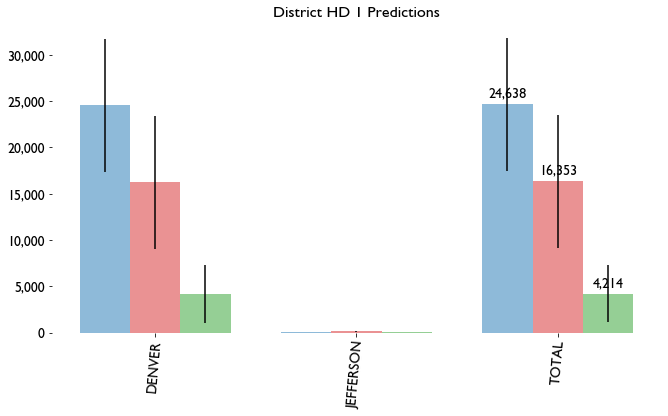

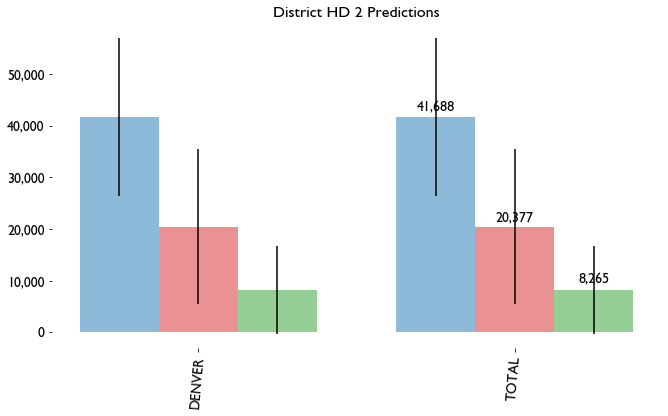

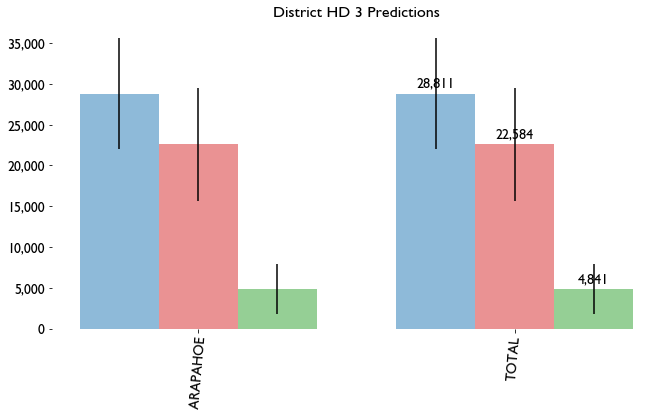

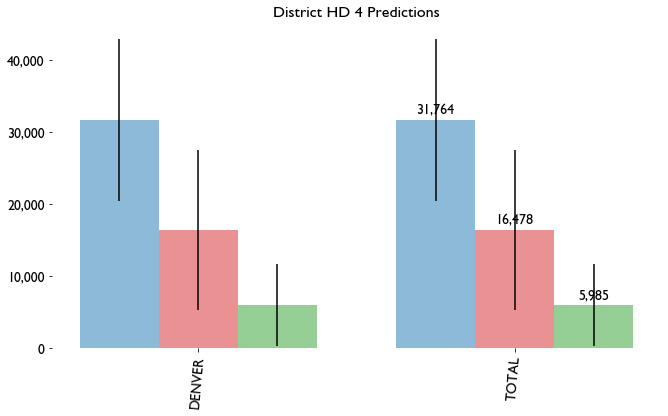

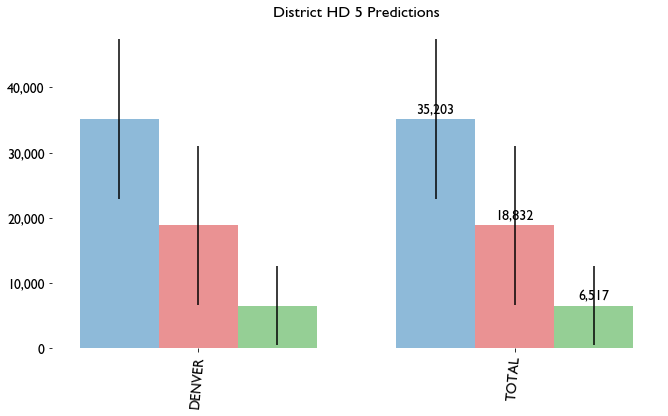

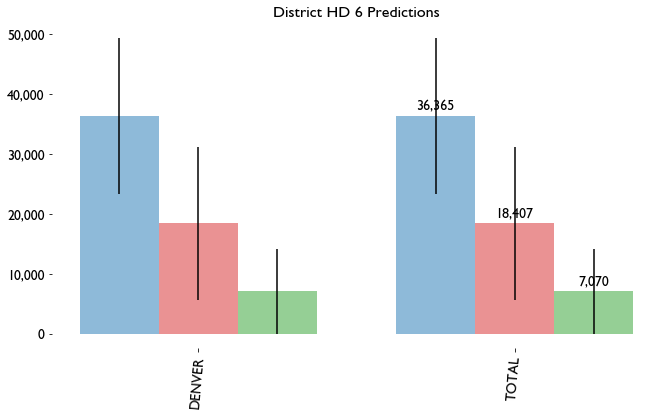

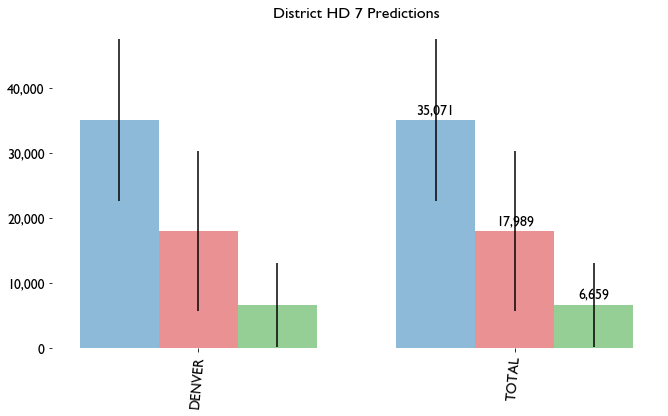

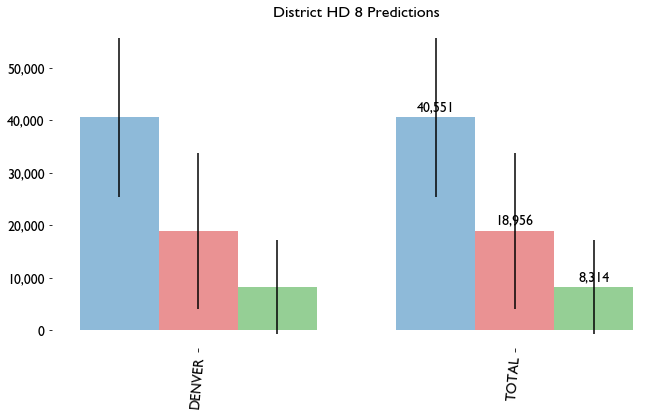

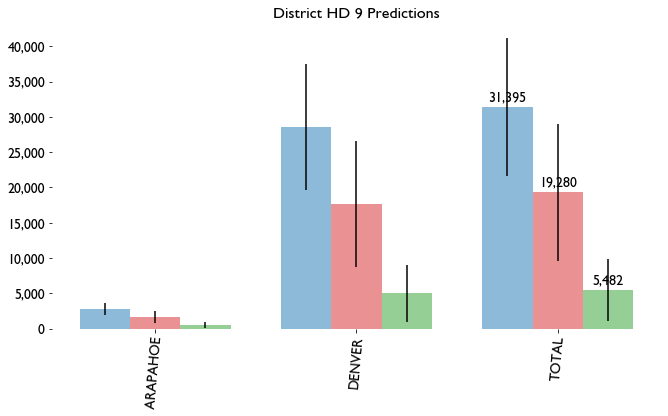

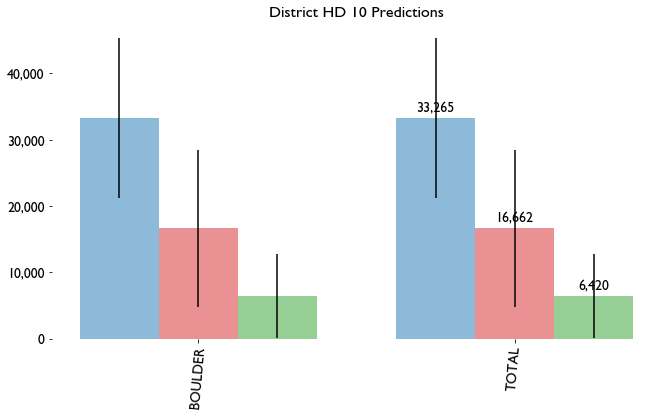

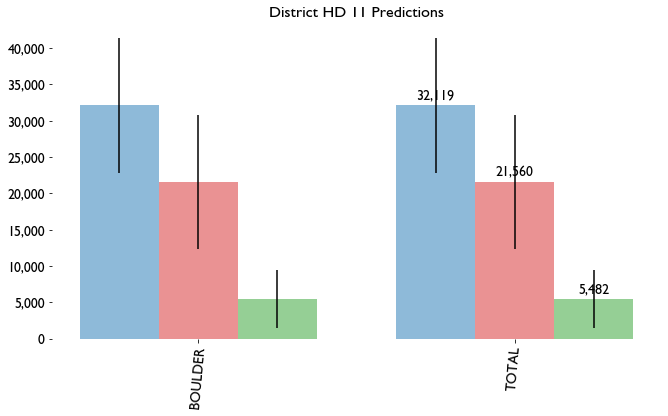

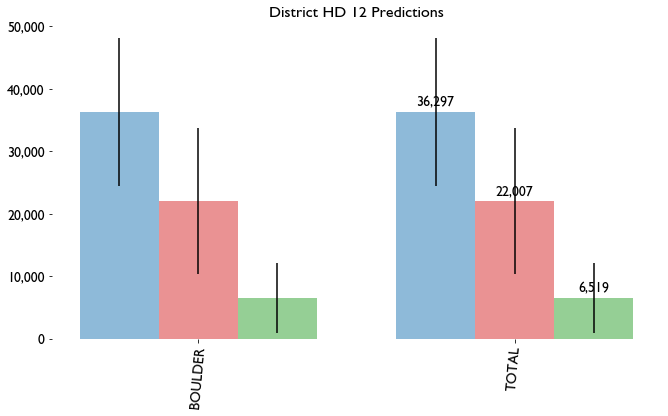

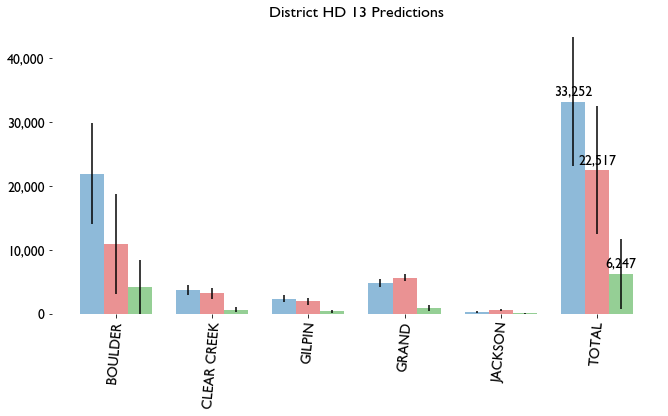

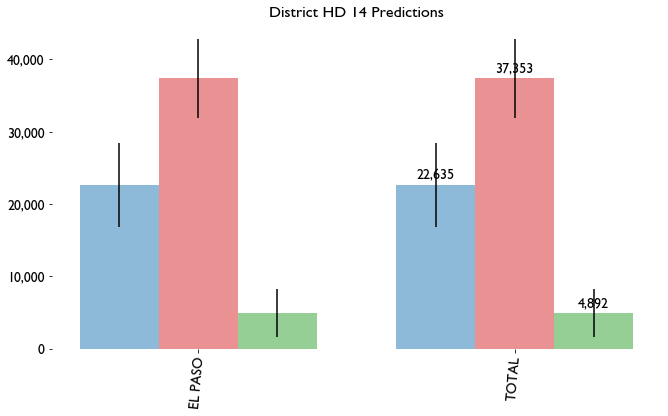

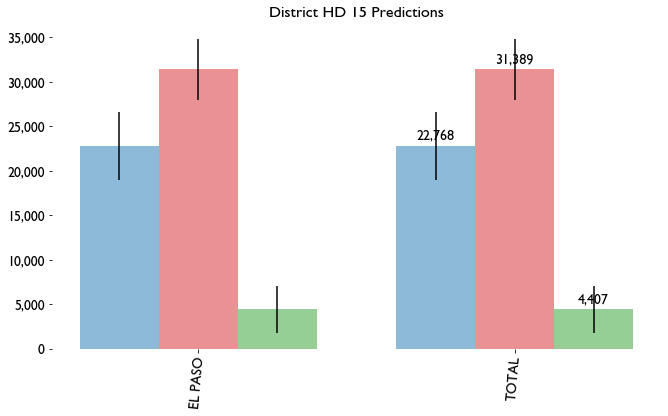

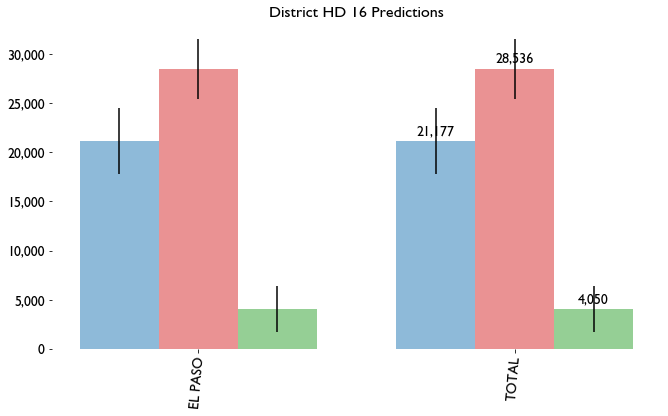

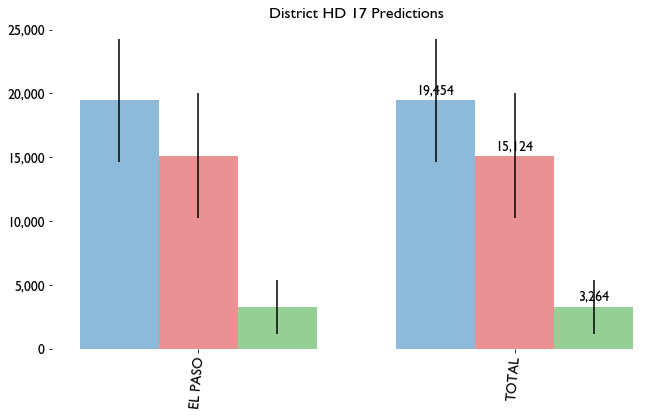

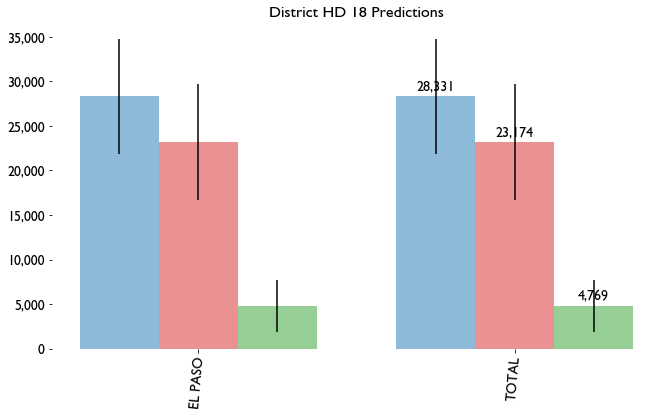

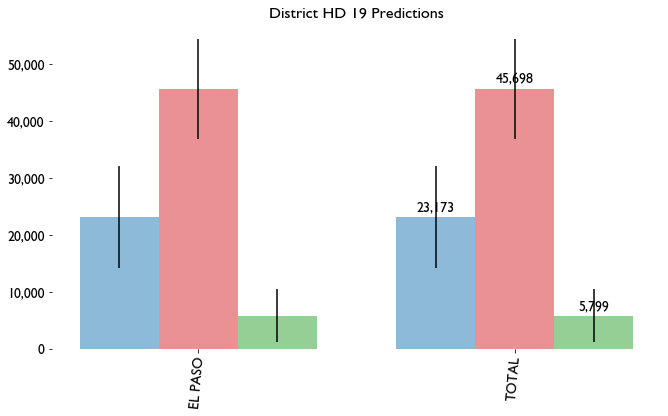

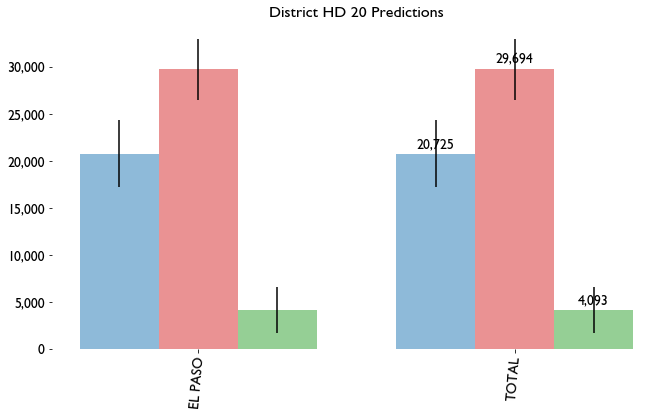

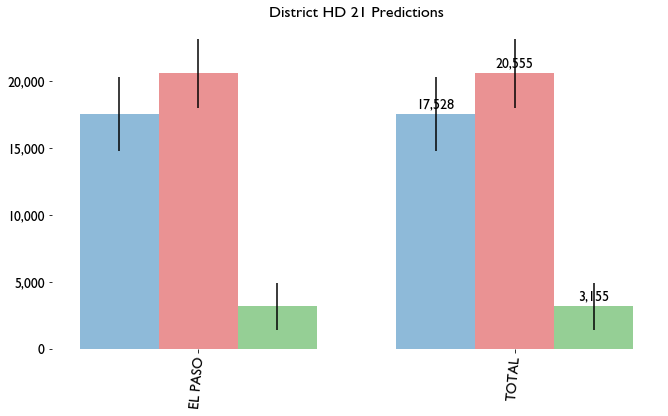

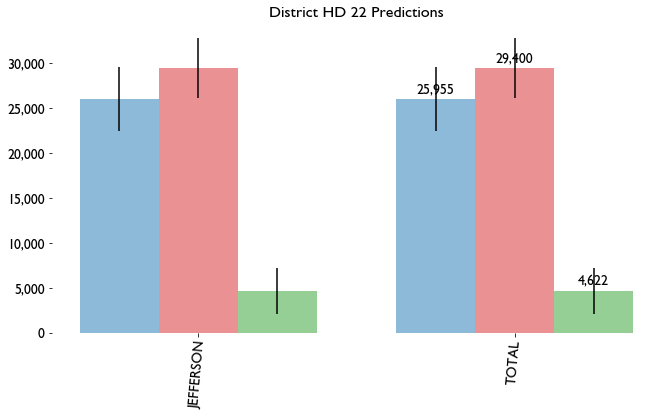

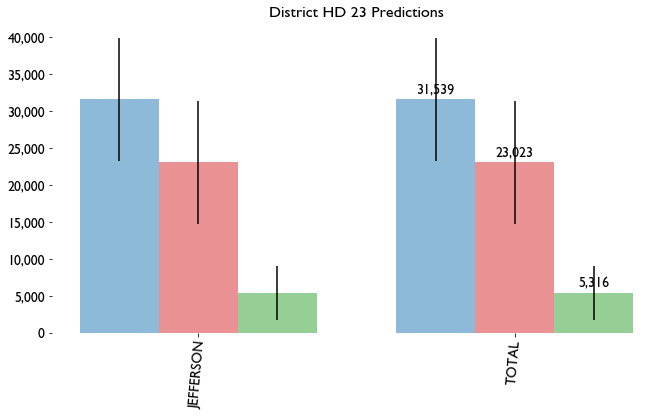

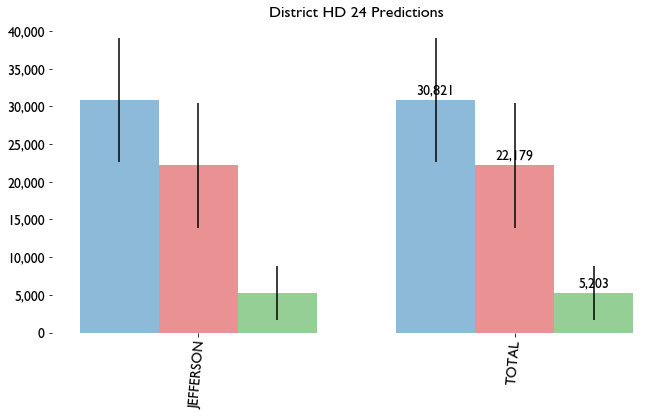

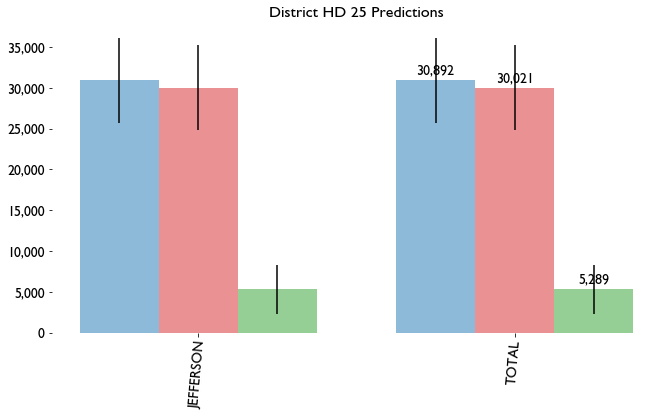

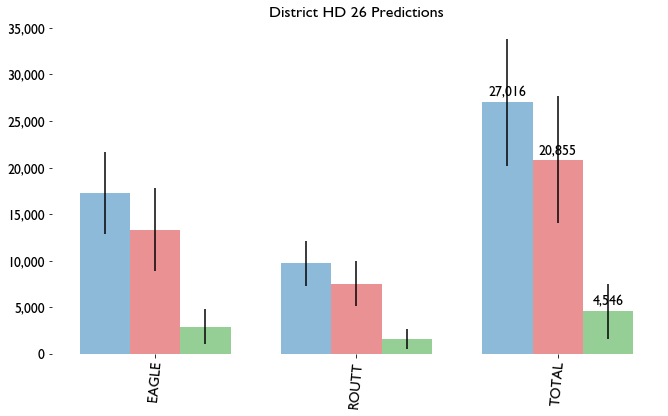

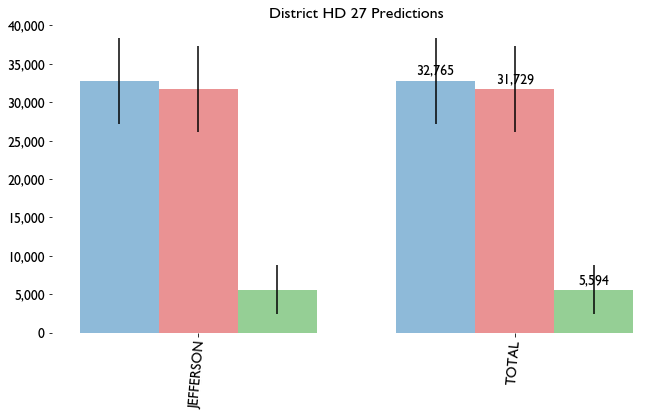

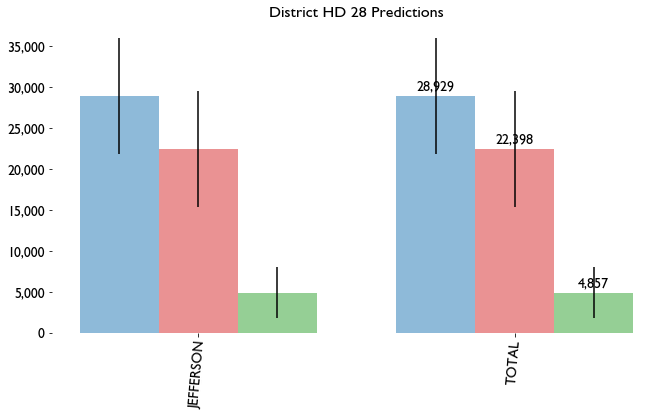

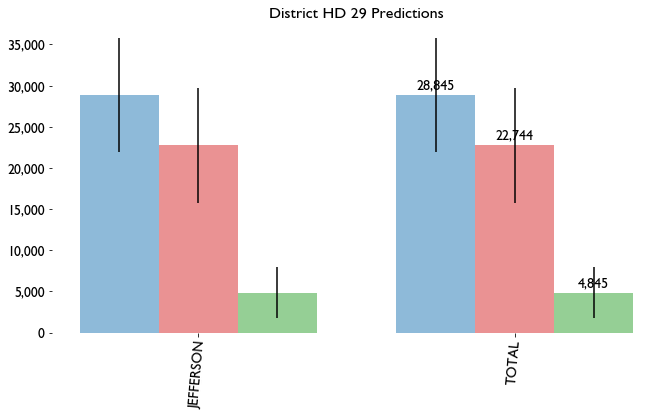

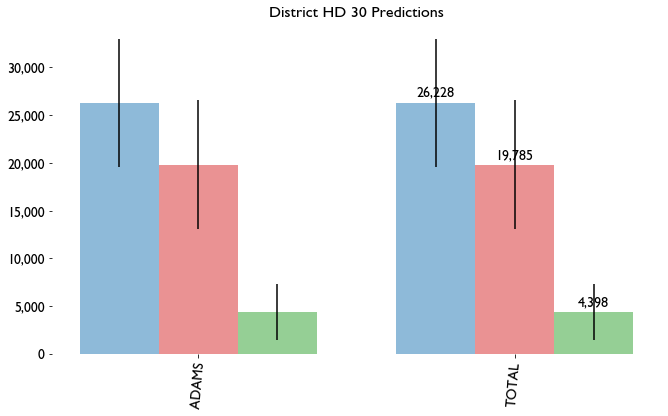

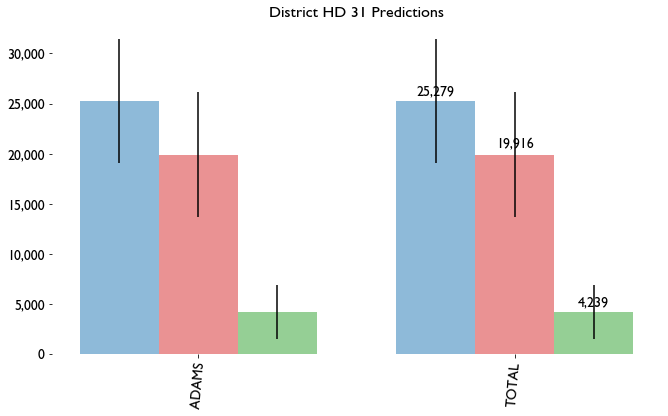

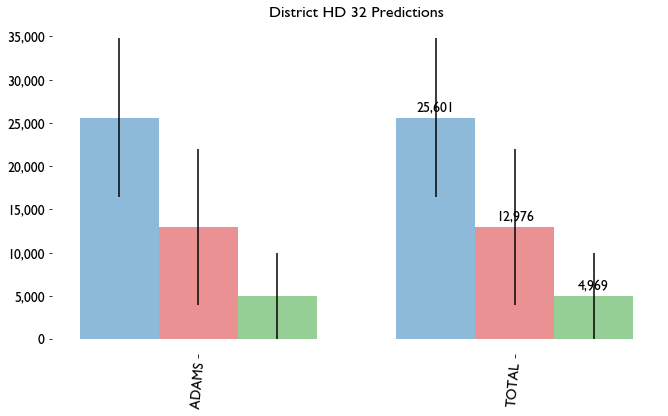

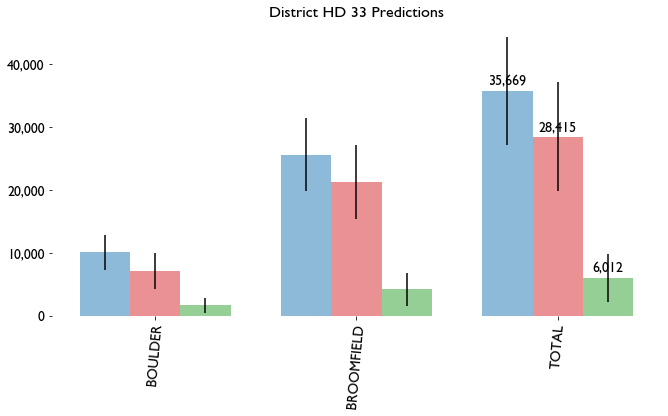

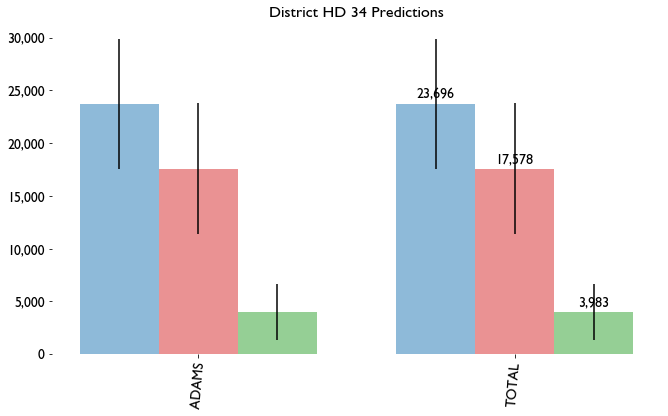

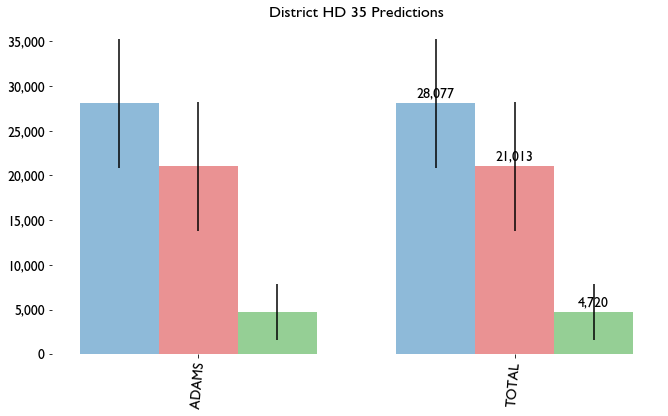

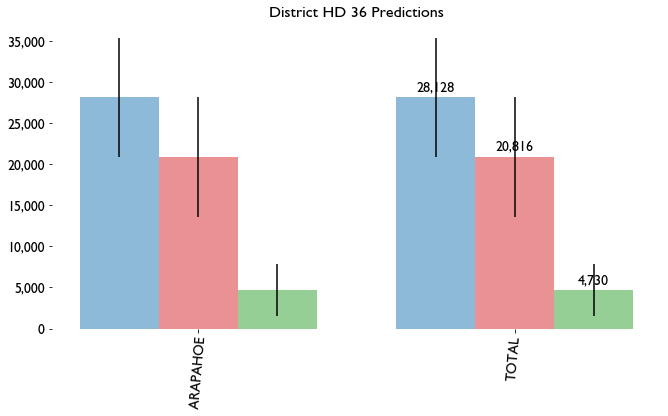

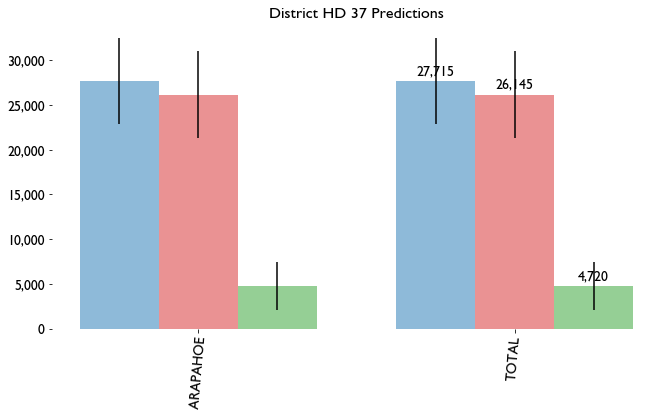

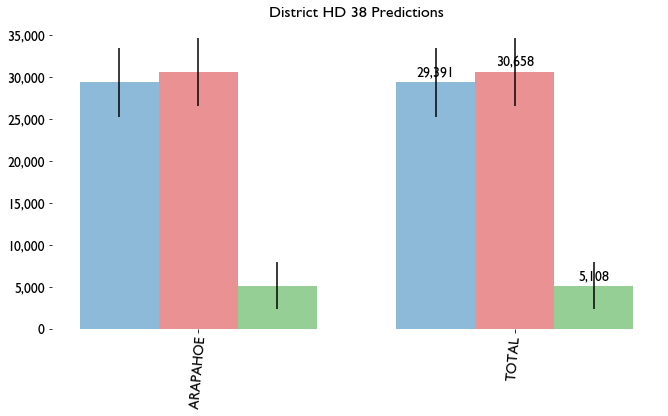

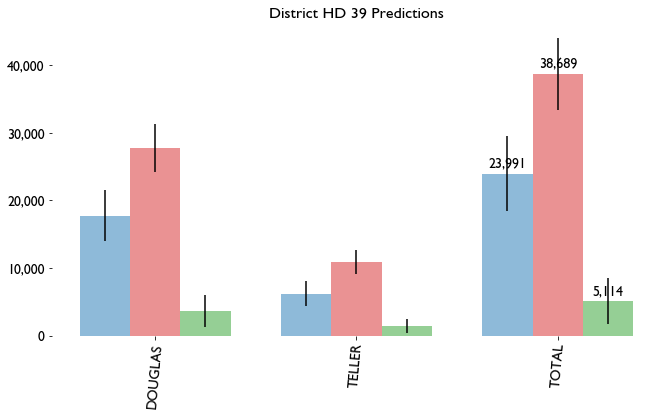

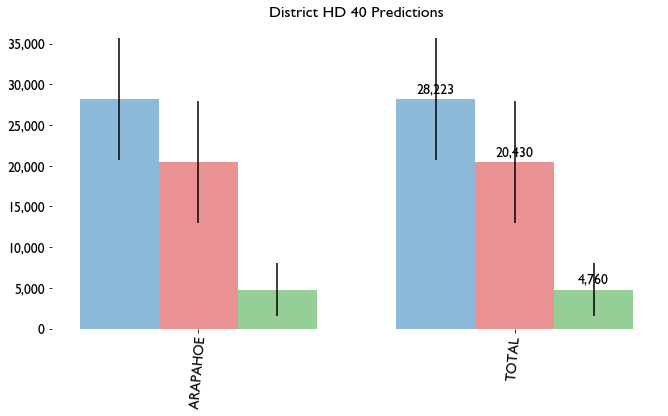

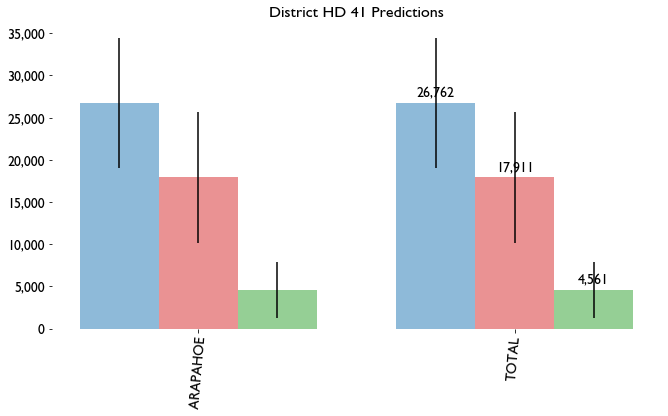

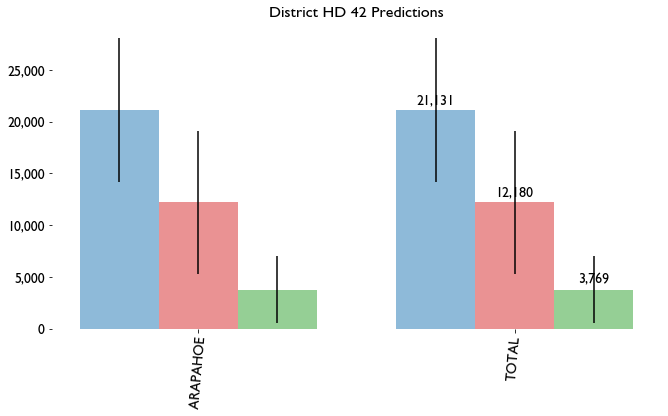

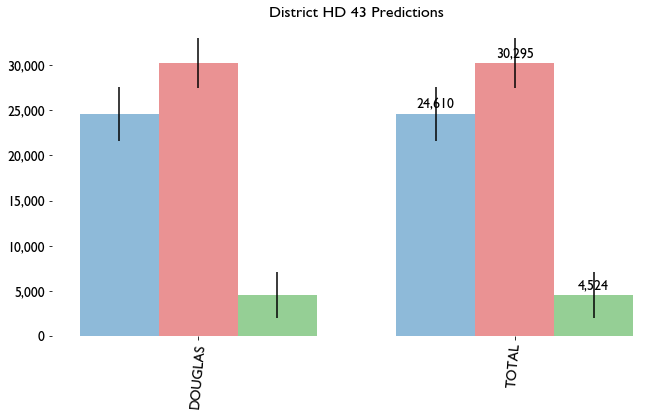

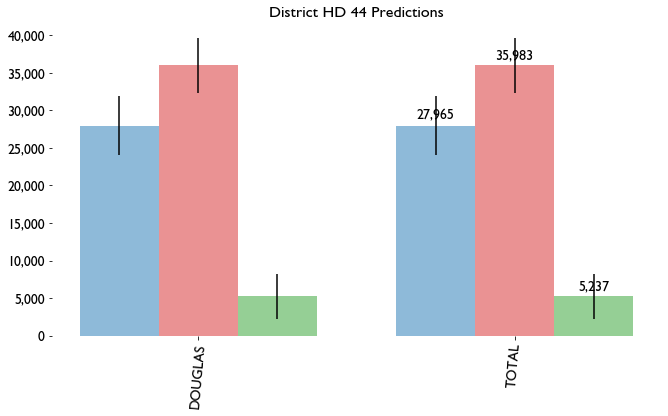

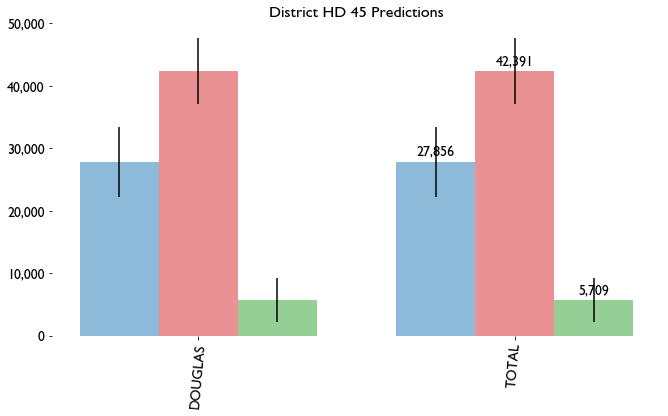

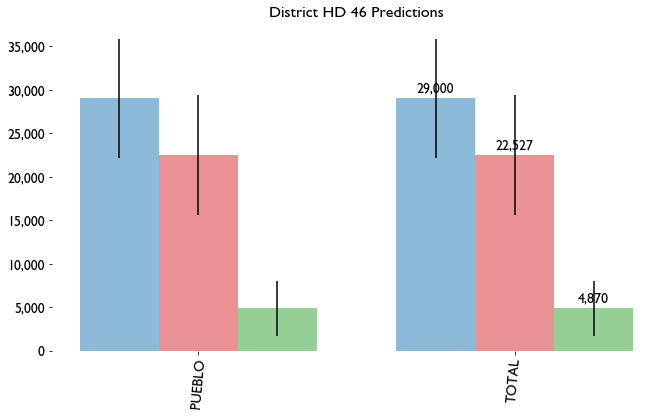

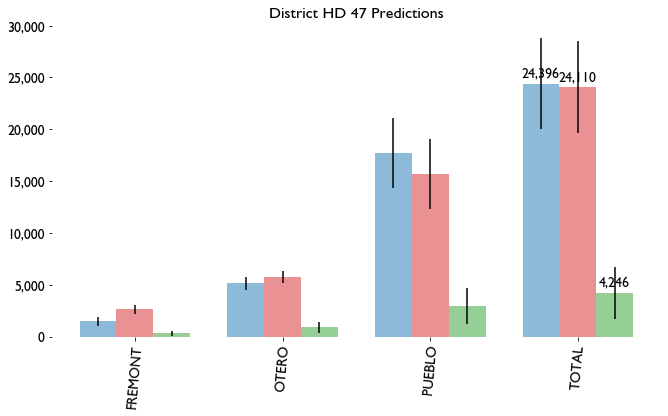

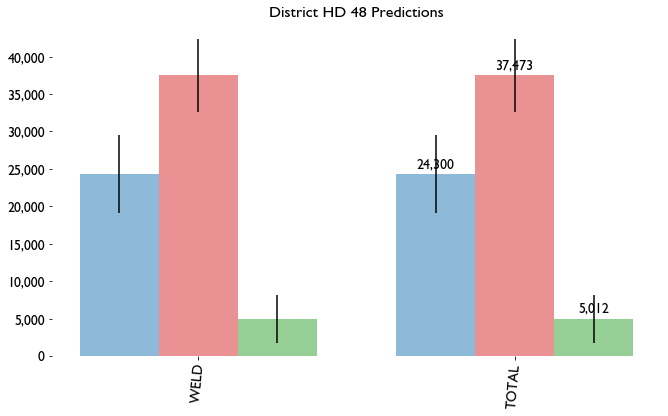

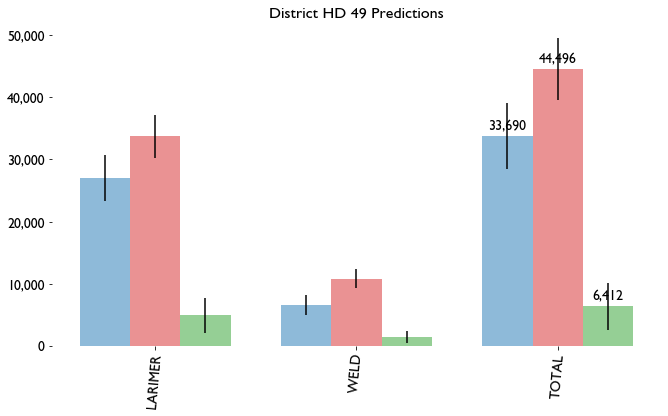

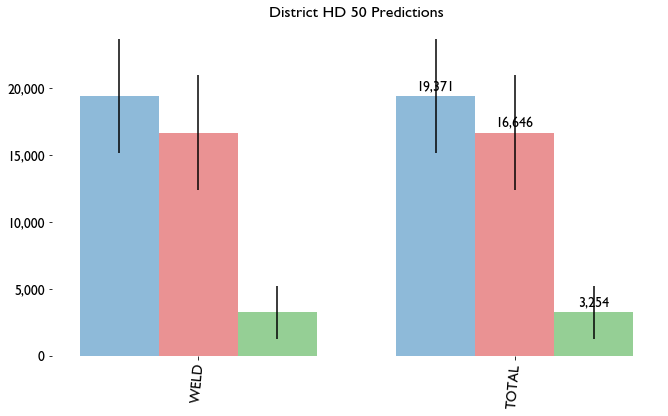

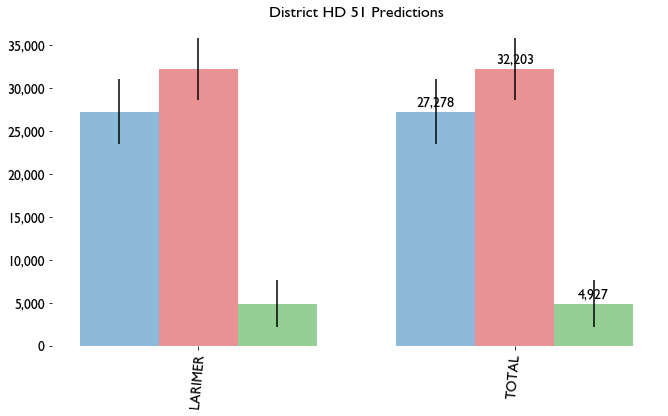

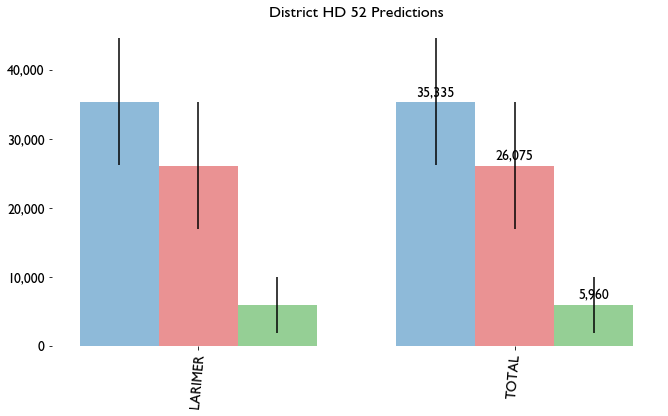

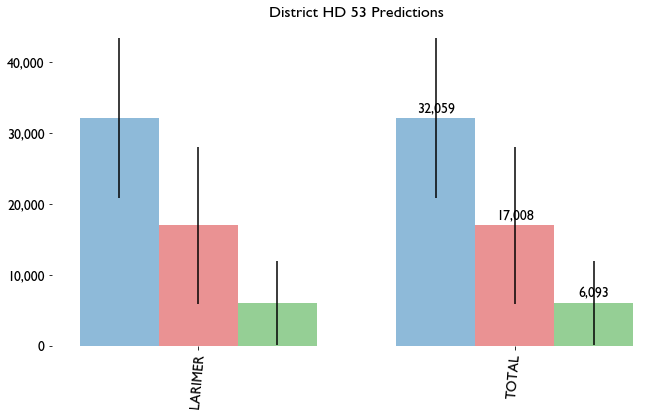

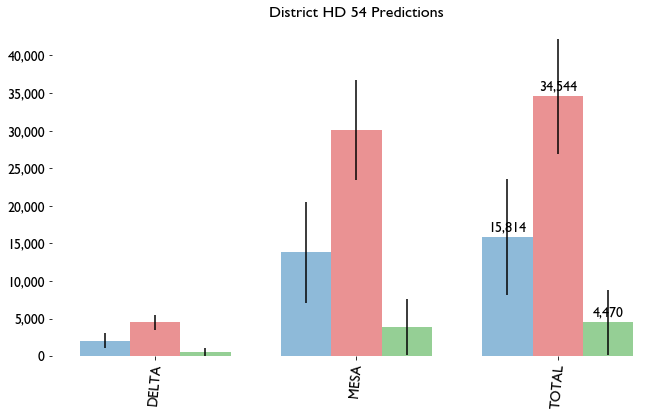

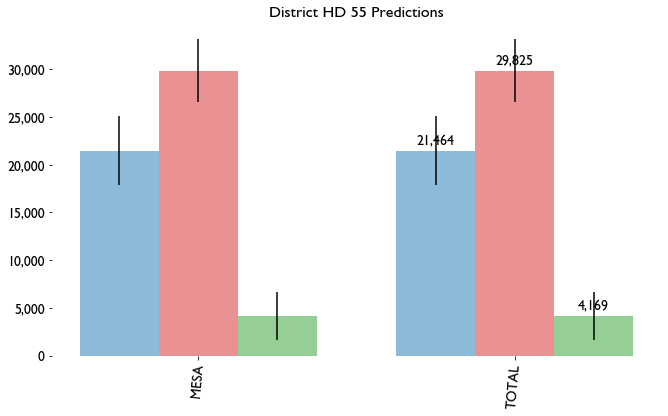

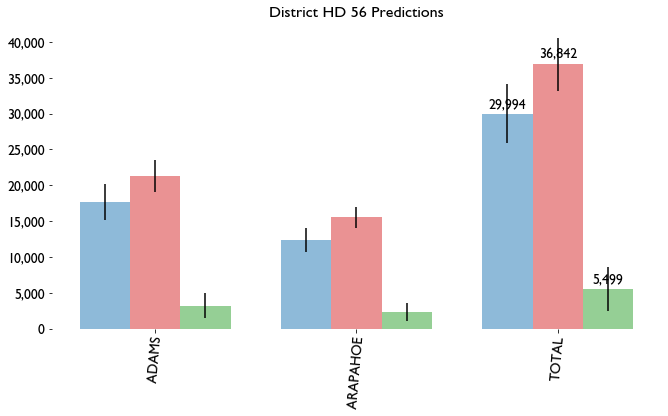

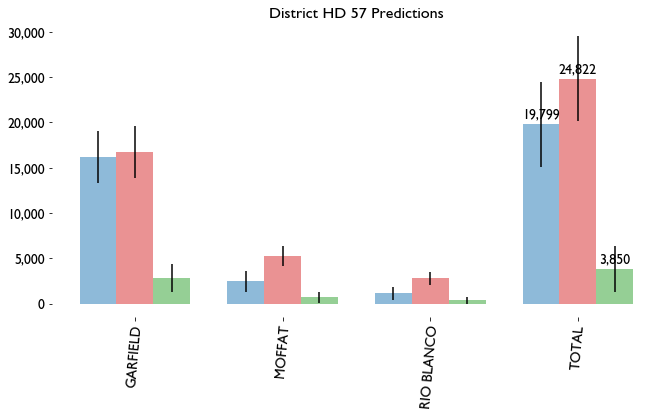

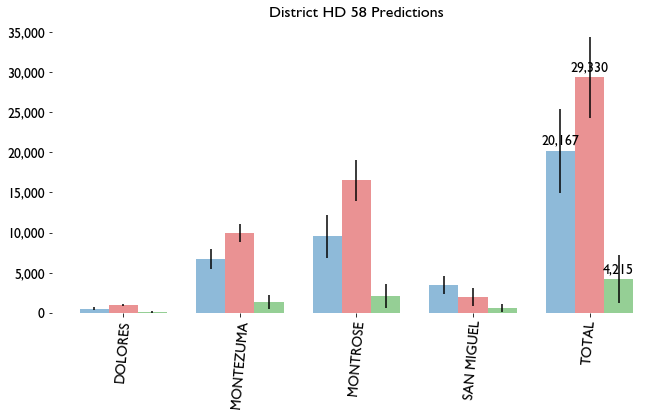

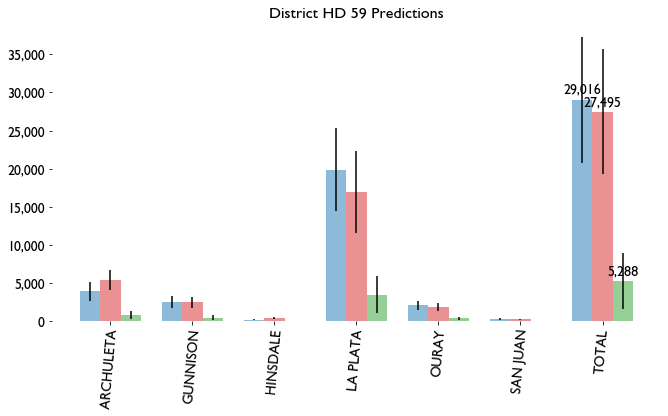

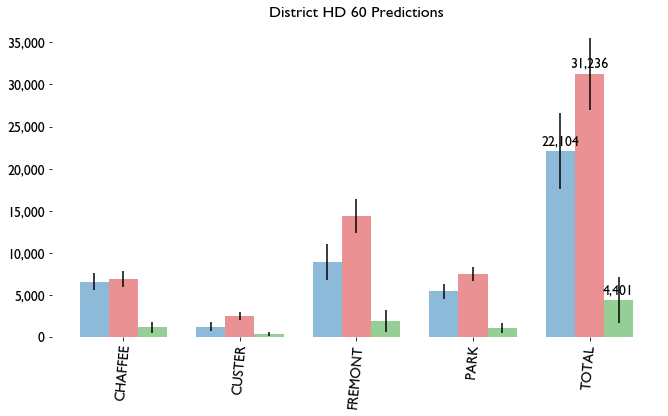

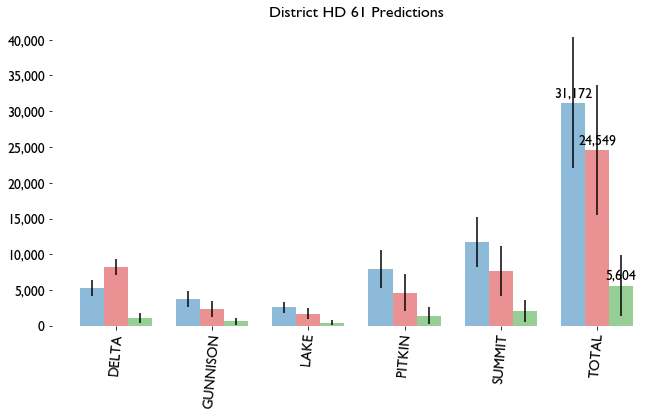

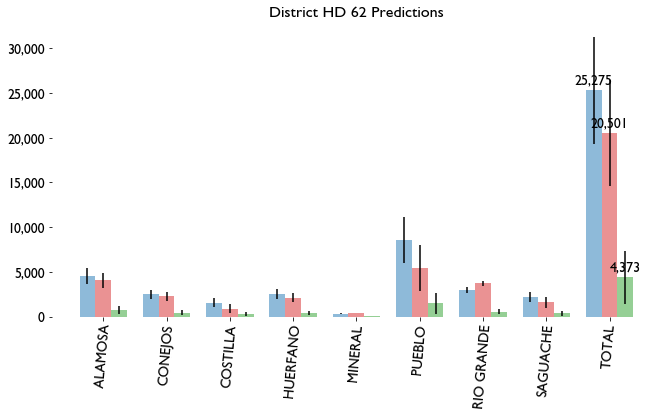

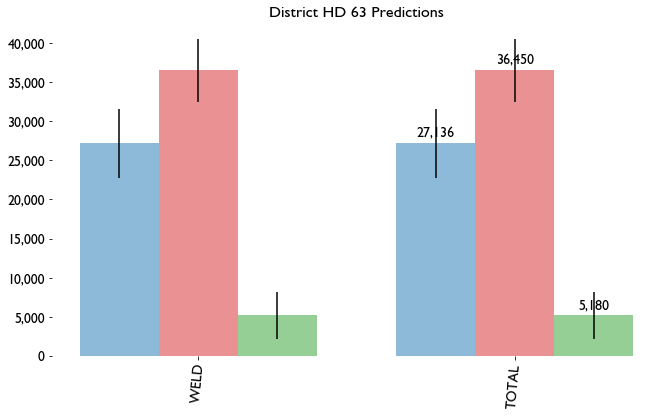

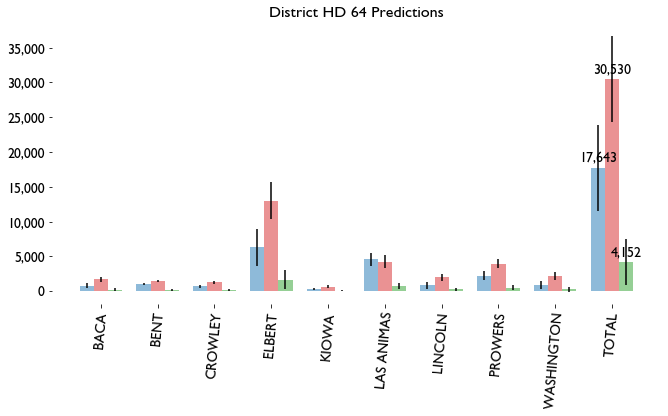

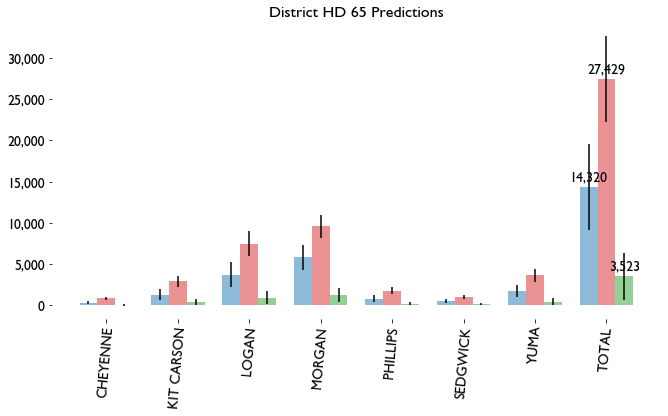

In [19]:
import matplotlib as mpl

# Use the Gill Sans font
import matplotlib.pylab as pylab

import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {
         'font.size': 14,
         'font.style': 'italic',
         'legend.fontsize': 14,
         'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)


width = .25

for district in mean_df.DISTRICT.unique():
    fig, ax = plt.subplots()
    
    ax.set_title('District {} Predictions'.format(district));
    
    counties = mean_df[mean_df.DISTRICT == district].COUNTY.values
    
    dem_votes   = mean_df[mean_df.DISTRICT == district].DEM.values
    rep_votes   = mean_df[mean_df.DISTRICT == district].REP.values
    other_votes = mean_df[mean_df.DISTRICT == district].OTHER.values
    
    dem_std   = std_df[mean_df.DISTRICT == district].DEM.values
    rep_std   = std_df[mean_df.DISTRICT == district].REP.values
    other_std = std_df[mean_df.DISTRICT == district].OTHER.values
    
    counties = np.append(counties, 'TOTAL')
    
    dem_votes = np.append(dem_votes, np.sum(dem_votes))
    dem_std = np.append(dem_std, np.sum(dem_std))
    
    rep_votes = np.append(rep_votes, np.sum(rep_votes))
    rep_std = np.append(rep_std, np.sum(rep_std))
    
    other_votes = np.append(other_votes, np.sum(other_votes))
    other_std = np.append(other_std, np.sum(other_std))
    
    
    x = np.arange(len(counties))
    
    ax.bar(x - width, dem_votes, width, label=counties, yerr=2.*dem_std, color='tab:blue', alpha=0.5);
    ax.bar(x, rep_votes, width, label=counties, yerr = 2.*rep_std, color='tab:red', alpha=0.5);
    ax.bar(x+width, other_votes, width, label=counties, yerr = 2.*other_std, color='tab:green', alpha=0.5);
    
    ax.set_xticks(x)
    for tick in ax.get_xticklabels():
        tick.set_rotation(85)
    ax.set_xticklabels(counties)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.annotate(format(int(dem_votes[-1]), ','),
            xy=(x[-1]-width, dem_votes[-1]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom');
    
    ax.annotate(format(int(rep_votes[-1]), ','),
            xy=(x[-1], rep_votes[-1]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom');
    
    ax.annotate(format(int(other_votes[-1]), ','),
            xy=(x[-1]+width, other_votes[-1]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom');
    
    
    fig.tight_layout()
    
    fig.savefig('../figs/forecasts/house/{}_projection.png'.format(district))

### Spread in Projections

Now we want to look at each model's predictions for each district, to figure out whether things are clustered, driven by outliers, etc. Key questions here are what percentage of models predict a Dem versus Rep win?

First, some data cleaning. Pandas doesn't like multidimensional arrays, so I'm using a dictionary instead.

In [26]:
print(np.shape(preds_array))
preds_array = np.array(preds_array)

preds_dict = {}

dem_votes = preds_array[:,:,0].T
rep_votes = preds_array[:,:,2].T
oth_votes = preds_array[:,:,1].T

dist_county = current_reg.DIST_COUNTY.values

for idx in range(len(dist_county)):
    preds_dict[dist_county[idx]] = preds_array[:,idx,:]

print(preds_dict.keys())


#dems_df = pd.DataFrame(data = {'DIST_COUNTY' : current_reg.DIST_COUNTY.values,
#                              'votes' : [dem_votes]})

(2000, 117, 3)
dict_keys(['HD 1-DENVER', 'HD 1-JEFFERSON', 'HD 2-DENVER', 'HD 3-ARAPAHOE', 'HD 4-DENVER', 'HD 5-DENVER', 'HD 6-DENVER', 'HD 7-DENVER', 'HD 8-DENVER', 'HD 9-ARAPAHOE', 'HD 9-DENVER', 'HD 10-BOULDER', 'HD 11-BOULDER', 'HD 12-BOULDER', 'HD 13-BOULDER', 'HD 13-CLEAR CREEK', 'HD 13-GILPIN', 'HD 13-GRAND', 'HD 13-JACKSON', 'HD 14-EL PASO', 'HD 15-EL PASO', 'HD 16-EL PASO', 'HD 17-EL PASO', 'HD 18-EL PASO', 'HD 19-EL PASO', 'HD 20-EL PASO', 'HD 21-EL PASO', 'HD 22-JEFFERSON', 'HD 23-JEFFERSON', 'HD 24-JEFFERSON', 'HD 25-JEFFERSON', 'HD 26-EAGLE', 'HD 26-ROUTT', 'HD 27-JEFFERSON', 'HD 28-JEFFERSON', 'HD 29-JEFFERSON', 'HD 30-ADAMS', 'HD 31-ADAMS', 'HD 32-ADAMS', 'HD 33-BOULDER', 'HD 33-BROOMFIELD', 'HD 34-ADAMS', 'HD 35-ADAMS', 'HD 36-ARAPAHOE', 'HD 37-ARAPAHOE', 'HD 38-ARAPAHOE', 'HD 39-DOUGLAS', 'HD 39-TELLER', 'HD 40-ARAPAHOE', 'HD 41-ARAPAHOE', 'HD 42-ARAPAHOE', 'HD 43-DOUGLAS', 'HD 44-DOUGLAS', 'HD 45-DOUGLAS', 'HD 46-PUEBLO', 'HD 47-FREMONT', 'HD 47-OTERO', 'HD 47-PUEBLO'

In [41]:
dists = mean_df.DISTRICT.unique()
print(dists)

dist_tots = {}

for dist in dists:
    tot_votes = 0
    for key in preds_dict.keys():
        if dist == key.split('-')[0]:
            tot_votes += preds_dict[key]
    
    dist_tots[dist] = tot_votes
    

['HD 1' 'HD 2' 'HD 3' 'HD 4' 'HD 5' 'HD 6' 'HD 7' 'HD 8' 'HD 9' 'HD 10'
 'HD 11' 'HD 12' 'HD 13' 'HD 14' 'HD 15' 'HD 16' 'HD 17' 'HD 18' 'HD 19'
 'HD 20' 'HD 21' 'HD 22' 'HD 23' 'HD 24' 'HD 25' 'HD 26' 'HD 27' 'HD 28'
 'HD 29' 'HD 30' 'HD 31' 'HD 32' 'HD 33' 'HD 34' 'HD 35' 'HD 36' 'HD 37'
 'HD 38' 'HD 39' 'HD 40' 'HD 41' 'HD 42' 'HD 43' 'HD 44' 'HD 45' 'HD 46'
 'HD 47' 'HD 48' 'HD 49' 'HD 50' 'HD 51' 'HD 52' 'HD 53' 'HD 54' 'HD 55'
 'HD 56' 'HD 57' 'HD 58' 'HD 59' 'HD 60' 'HD 61' 'HD 62' 'HD 63' 'HD 64'
 'HD 65']


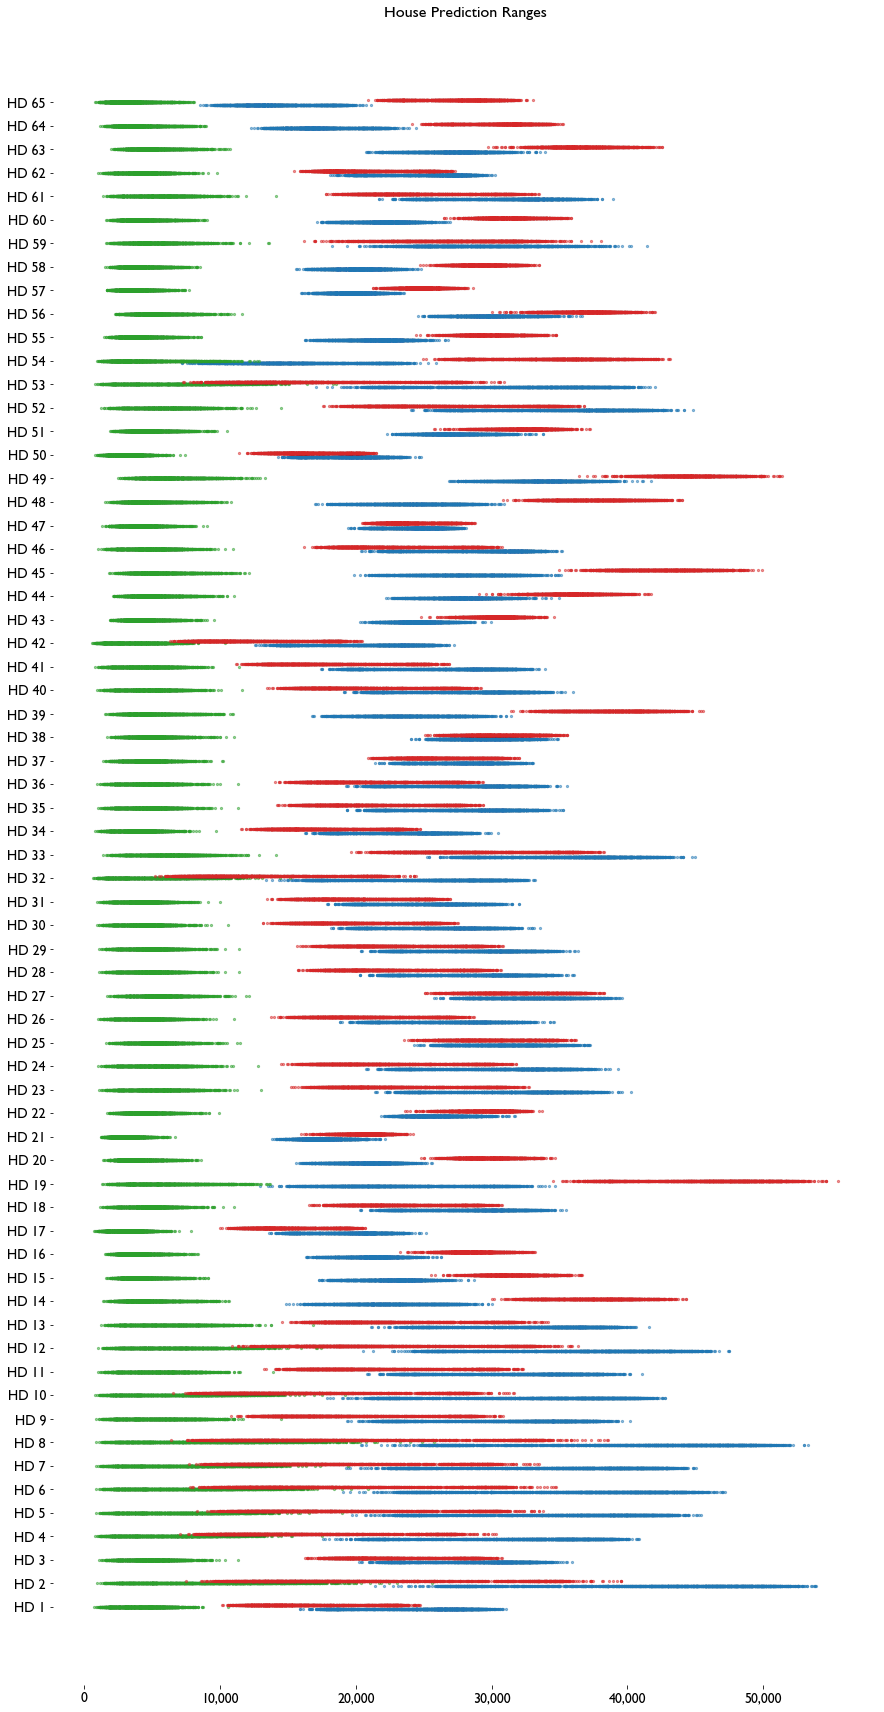

In [64]:
fig, ax = plt.subplots(figsize=(12.5, 24))
xticks = np.linspace(0,10*(len(dists)-1), len(dists))
for idx, dist in enumerate(dists):

    ax.scatter(dist_tots[dist][:,0], [xticks[idx]-1]*np.shape(dist_tots[dist])[0], c='tab:blue', alpha=0.5, s=5);
    ax.scatter(dist_tots[dist][:,1], [xticks[idx]]*np.shape(dist_tots[dist])[0],  c='tab:green', alpha=0.5, s=5);
    ax.scatter(dist_tots[dist][:,2], [xticks[idx]+1]*np.shape(dist_tots[dist])[0],  c='tab:red', alpha=0.5, s=5);
    
ax.set_yticks(xticks);
ax.set_yticklabels(dists, rotation='horizontal', fontsize=14);
ax.set_title('House Prediction Ranges');
ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
fig.tight_layout();
fig.savefig('house_full_predictions.png');